##### Teoretiska frågor 
1. Beskriv kort hur en relationsdatabas fungerar.

I en databas samlas information på ett sätt som gör det lätt att söka efter, hämta och ändra i hela eller delar av informationen. I en relationsdatabas är informationen strukturerad i tabeller (relationer). Varje tabell består av rader, individuella dataposter, och kolumner, attribut eller egenskaper för data. Varje tabell har en primärnyckel som unikt definerar varje rad. En tabell länkas till andra tabeller (relationer tabeller emellan) med hjälp av en främmande nyckel. 
En relationsdatabas använder SQL för att utföra operationer som att skapa, läsa, uppdatera och ta bort data.

2. Vad menas med “CRUD”-flödet?

De fyra grundläggande operationerna som används för att hantera data i en databas. 
Create: Skapa tabeller och lägga till nya rader i en tabell. 
Read: Hämta data från tabeller. 
Update: Uppdatera/Ändra data i tabeller.
Delete: Radera data i tabeller.  

3. Beskriv kort vad en “left join” och en “inner join” är. Varför använder man det?

JOIN i SQL används för att kombinera kolumner från en eller flera tabeller till en ny tabell. 

INNER JOIN: Returnerar endast de rader som det finns en match till i båda tabellerna. Används när man endast vill ha data som är gemensam två tabeller emellan. 
LEFT JOIN: Returnerar alla rader från den 'vänstra' tabellen, även om det inte finns någon match i den 'högra' tabellen. För de rader utan match fylls värdena med NULL. Används när man vill se all data från en tabell och lägga till eventuell data som finns från en annan tabell. 

4. Beskriv kort vad indexering i SQL innebär.

Vid indexering organiseras datan i en tabell på ett sätt som gör det snabbare att hitta och läsa specifika rader i en tabell. Ett index är som en bokstavsregister eller innehållsförteckning i en bok. Utan indexering måste systemet gå igenom tabellen rad för rad vid sökning. 

Fördel: Det går snabbare att söka igenom data. 
Nackdel: Det går långsammare att lägga till, uppdatera och ta bort data.

5. Beskriv kort vad en vy i SQL är.

En vy är en virtuell tabell som baseras på resultatet från en SQL-query. Datan i en vy lagras inte i databasen, utan själva frågan lagras. Tabellen skapas dynamiskt när querien körs. Detta gör att data alltid är uppdaterad. 

Vyer är ett bra verktyg för att förenkla, säkra och organisera queries. Hjälper användaren att slippa skriva komplexa frågor om och om igen, användaren behöver inte känna till den underliggande strukturen av databasen och åtkomst till känsliga kolumner kan begränsas. 

6. Beskriv kort vad en lagrad procedur i SQL är.

En lagrad procedur är en lagrad programkod som kan köras vid behov. Precis som en vy lagras inte data, utan själva frågan lagras. Till skillnad från en vy, som endast visar data, kan man även uppdatera och ta bort data med hjälp av en lagrad procedur. En lagrad procedur stödjer även mer komplexa operationer såsom loopar och villkor. 

--------------------------------------------------------------------------------------------------------------------------------------------

##### Exekutiv sammanfattning
USA-baserat företag med försäljning av cyklar och cykeldelar världen över. 

Företaget startade 2006 och har sedan dess varit på en tillväxtresa. Anställningar inom framför allt produktion gjordes tidigt för att bygga upp verksamheten. Försäljning startade först några år senare och med det utökades personalstyrkan med säljare. Skillnader inom anställningstid för olika avdelningar förklaras med när anställning för respektive avdelning började snarare än att någon avdelning har en högre personalomsättning. 

Kvinnor i företaget har i genomsnitt en högre lön, skillnaden är dock inte statistiskt säkerställd. Andelen av anställda kvinnor som har chefspositioner är högre än för män, vilket kan vara en förklaring till skillnaden. En analys som inkluderar till exempel roll, kön, avdelning, anställningstid, ålder, utbildningsnivå behöver göras för att säkerställa vad skillnader i lön faktiskt beror på. 

--------------------------------------------------------------------------------------------------------------------------------------------

##### Importera bibliotek och sätt upp database connection

In [4]:
# Import libraries and set up database connection.
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import geopandas as gpd
import plotly.express as px
from shapely import wkt

from scipy import stats
from scipy.stats import t, sem, ttest_ind
from tabulate import tabulate

# Connect to SQL-Server database with Windows Authentication
DATABASE_URL = "mssql+pyodbc://TERESE/AdventureWorks2022?driver=ODBC+Driver+17+for+SQL+Server"

engine = create_engine(DATABASE_URL)
connection = engine.connect()

##### Bakgrund AdventureWorks-databasen
Databasen representerar ett företag som producerar och säljer cyklar och cykeldelar. 
Databasen innehåller information om anställda, försäljning, kunder och produktion. 
Eftersom databasen innehåller kopplingar mellan olika områden är det möjligt att analysera samband mellan försäljning, lager och anställda. 

In [78]:
# Query that retrives all user schemas from the database for an overview of what the database contains. System schemas are excluded. 

query = """
SELECT name AS 'User schemas'
FROM sys.schemas 
WHERE name NOT IN ('sys', 'guest', 'INFORMATION_SCHEMA', 'db_owner', 'db_accessadmin', 
                   'db_securityadmin', 'db_ddladmin', 'db_backupoperator', 
                   'db_datareader', 'db_datawriter', 'db_denydatareader', 
                   'db_denydatawriter')
"""
df = pd.read_sql_query(query, engine)
print(df)


     User schemas
0             dbo
1  HumanResources
2          Person
3      Production
4      Purchasing
5           Sales


In [79]:
# Organizational schedule including the number of employees per department and role.

# Query that retrives department, organization level and job title for each employee.
# The data is then grouped by all three to make it possibe to count how many employees share the same position. 
# The organization level is divided into four categories: Top manager, Middle manager, Team lead and employee.
# All Production supervisors and Production technichians are considered to be the same role. 
query = """
SELECT 
    ED.Department,
    CASE 
        WHEN E.OrganizationLevel IS NULL THEN 'Top Manager' -- Missing data for CEO. Update in AdventureWorks in real life? 
        WHEN E.OrganizationLevel = 1 THEN 'Top Manager'
        WHEN E.OrganizationLevel = 2 THEN 'Middle Manager'
        WHEN E.OrganizationLevel = 3 THEN 'Team Lead'
        ELSE 'Employee'
    END AS RoleLevel,
    CASE 
        WHEN E.JobTitle LIKE 'Production Supervisor%' THEN 'Production Supervisor'
        WHEN E.JobTitle LIKE 'Production Technician%' THEN 'Production Technician'
        ELSE E.JobTitle
    END AS JobTitle,
    COUNT(*) AS Count
FROM HumanResources.Employee AS E
INNER JOIN HumanResources.vEmployeeDepartment AS ED
    ON E.BusinessEntityID = ED.BusinessEntityID
GROUP BY 
    ED.Department, 
    E.OrganizationLevel, 
    CASE 
        WHEN E.JobTitle LIKE 'Production Supervisor%' THEN 'Production Supervisor'
        WHEN E.JobTitle LIKE 'Production Technician%' THEN 'Production Technician'
        ELSE E.JobTitle
    END
"""
df = pd.read_sql(query, engine)

# Function that creates a string with the hierarchy within the company from a dataframe.
# Iterates over each unique department, then the different organization levels within each department to find all job titels and the count of employees. 
def build_hierarchy_text(df):
    text_representation = ""
    departments = df["Department"].unique()

    for department in departments:
        text_representation += f"{department}\n" 

        department_data = df[df["Department"] == department]

        levels = ["Top Manager", "Middle Manager", "Team Lead", "Employee"]
        for level in levels:
            level_data = department_data[department_data["RoleLevel"] == level]

            for _, row in level_data.iterrows():
                indent = "│   " * (levels.index(level))
                text_representation += f"{indent}├── {row['JobTitle']} ({row['Count']})\n"

    return text_representation

text_hierarchy = build_hierarchy_text(df)
print(text_hierarchy)

Document Control
│   │   ├── Document Control Manager (1)
│   │   │   ├── Control Specialist (2)
│   │   │   ├── Document Control Assistant (2)
Engineering
├── Vice President of Engineering (1)
│   ├── Engineering Manager (1)
│   │   ├── Design Engineer (3)
│   │   ├── Senior Design Engineer (1)
Executive
├── Chief Executive Officer (1)
├── Chief Financial Officer (1)
Facilities and Maintenance
│   ├── Facilities Manager (1)
│   │   ├── Facilities Administrative Assistant (1)
│   │   ├── Maintenance Supervisor (1)
│   │   │   ├── Janitor (4)
Finance
│   ├── Accounts Manager (1)
│   ├── Assistant to the Chief Financial Officer (1)
│   ├── Finance Manager (1)
│   │   ├── Accountant (2)
│   │   ├── Accounts Payable Specialist (2)
│   │   ├── Accounts Receivable Specialist (3)
Human Resources
│   ├── Human Resources Manager (1)
│   │   ├── Benefits Specialist (1)
│   │   ├── Human Resources Administrative Assistant (2)
│   │   ├── Recruiter (2)
Information Services
├── Information Services

In [ ]:
# Map of sales, production and headquarter locations.

# Query that retrives locations for stores and production and executive employees.
query = '''
SELECT 
    CASE 
        WHEN D.Name IN ('Production', 'Executive') THEN 
            CASE 
                WHEN D.Name = 'Production' THEN 'Production'
                WHEN D.Name = 'Executive' THEN 'Headquarter'
            END
        ELSE 'Store'
    END AS Type,
    COALESCE(S.Name, P.FirstName + ' ' + P.LastName) AS Name,
    A.City AS City,
    A.SpatialLocation.STAsText() AS Location
FROM 
    Person.Address A
LEFT JOIN Person.BusinessEntityAddress BEA
    ON A.AddressID = BEA.AddressID
LEFT JOIN Sales.vStoreWithAddresses S
    ON BEA.BusinessEntityID = S.BusinessEntityID
LEFT JOIN HumanResources.Employee E
    ON BEA.BusinessEntityID = E.BusinessEntityID
LEFT JOIN Person.Person P
    ON E.BusinessEntityID = P.BusinessEntityID
LEFT JOIN HumanResources.EmployeeDepartmentHistory EDH
    ON E.BusinessEntityID = EDH.BusinessEntityID
LEFT JOIN HumanResources.Department D
    ON EDH.DepartmentID = D.DepartmentID
WHERE 
    A.SpatialLocation IS NOT NULL 
    AND (D.Name IS NULL OR (EDH.EndDate IS NULL AND D.Name IN ('Production', 'Executive')))
'''

df = pd.read_sql(query, engine)

# Create GeoDataFrame
df['Location'] = df['Location'].apply(lambda x: wkt.loads(x) if x else None)
gdf = gpd.GeoDataFrame(df, geometry='Location')
gdf = gdf.set_crs(epsg=4326)

# Plot data
fig = px.scatter_mapbox(
    gdf,
    lat=gdf.geometry.y,
    lon=gdf.geometry.x,
    zoom=2,
    color='Type',
    opacity=0.75,
    title='Store, Production and HQ Locations',
    hover_name='Name',
    hover_data={'City': True, 'Type': True}
)

fig.update_layout(mapbox_style='carto-positron', height=750)
fig.show()

Jag har plottat företagets butiker världen över. Företaget har försäljning i Nordamerika, Europa och Australien. 
Det verkar som att en punkt utanför Afrika har felaktig data i databasen. 
Då jag inte lyckats ta fram koordinater för produktionsanläggningar för företaget har jag istället valt att i kartan plotta
vart anställda inom avdelningen Produktion är placerade. Alla dessa är placerade i nordvästra USA. 
Jag har även plottat vart anställda inom avdelningen Executive är placerade. Dessa två sitter även de i nordvästra USA.
Med ovan information drar jag slutsatsen att huvudkontor/ledning och produktion är placerade i USA, medan försäljning sker på flera kontinenter i världen. 

In [101]:
# The company's products by category to provide an overview of the product catalog.

# Query that retrives Product category and Product subcategory. 
query = """
SELECT 
    PC.Name AS ProductCategory,
    PSC.Name AS ProductSubcategory
FROM 
    Production.ProductCategory AS PC
LEFT JOIN 
    Production.ProductSubcategory AS PSC
    ON PC.ProductCategoryID = PSC.ProductCategoryID
ORDER BY 
    PC.Name ASC,
    PSC.Name ASC;
"""

df = pd.read_sql(query, engine)
print(df)

   ProductCategory ProductSubcategory
0      Accessories         Bike Racks
1      Accessories        Bike Stands
2      Accessories  Bottles and Cages
3      Accessories           Cleaners
4      Accessories            Fenders
5      Accessories            Helmets
6      Accessories    Hydration Packs
7      Accessories             Lights
8      Accessories              Locks
9      Accessories           Panniers
10     Accessories              Pumps
11     Accessories    Tires and Tubes
12           Bikes     Mountain Bikes
13           Bikes         Road Bikes
14           Bikes      Touring Bikes
15        Clothing         Bib-Shorts
16        Clothing               Caps
17        Clothing             Gloves
18        Clothing            Jerseys
19        Clothing             Shorts
20        Clothing              Socks
21        Clothing             Tights
22        Clothing              Vests
23      Components    Bottom Brackets
24      Components             Brakes
25      Comp

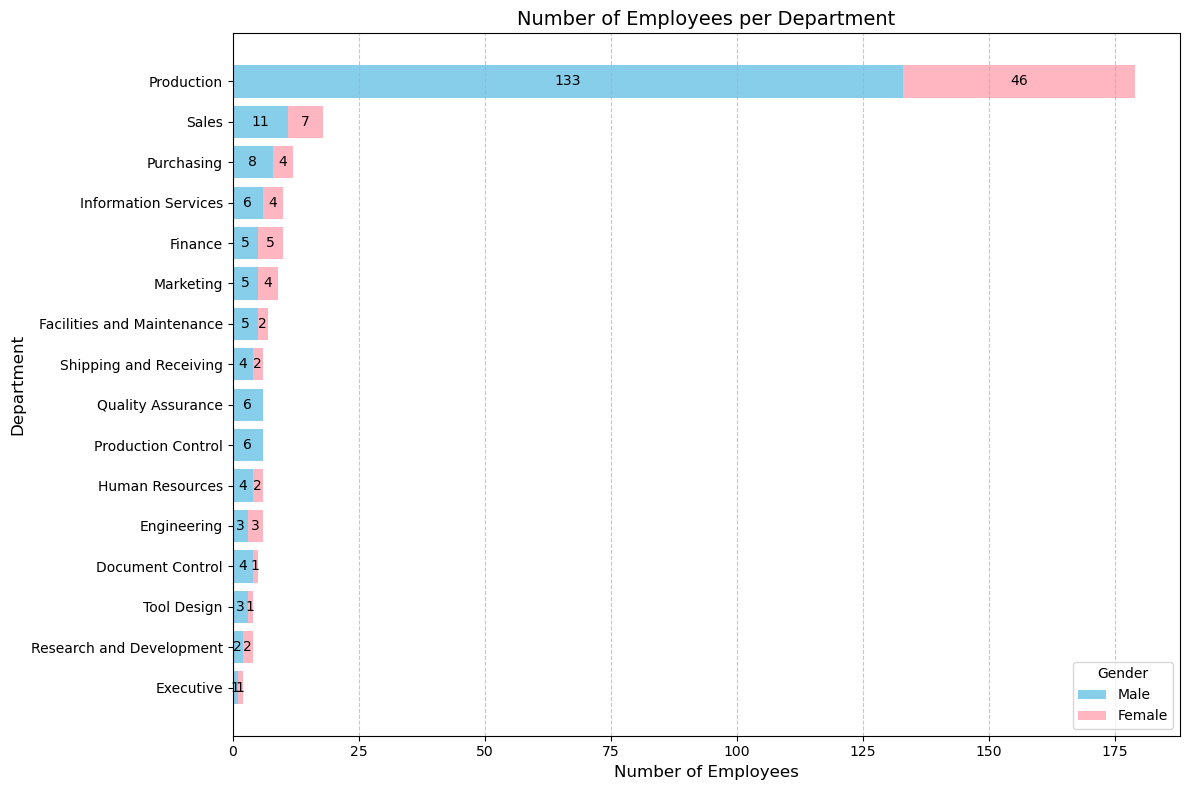

In [110]:
# The number of employees by department and gender.

# Query that retrives number of employees by department and gender and order it by the deparment with most employees first. 
query = """
SELECT 
    ED.Department, 
    E.Gender, 
    COUNT(*) AS EmployeeCount,
    SUM(COUNT(*)) OVER (PARTITION BY ED.Department) AS TotalEmployees
FROM HumanResources.Employee AS E
INNER JOIN HumanResources.vEmployeeDepartment AS ED
    ON E.BusinessEntityID = ED.BusinessEntityID
GROUP BY 
    ED.Department, 
    E.Gender
ORDER BY 
    TotalEmployees,
    ED.Department;
"""
df = pd.read_sql(query, engine)
pivot_df = df.pivot(index="Department", columns="Gender", values="EmployeeCount").fillna(0)
pivot_df["Total"] = pivot_df["M"] + pivot_df["F"]
pivot_df = pivot_df.sort_values(by="Total", ascending=True)

# Data for plot
departments = pivot_df.index
male_departments = pivot_df["M"]  # Male data
female_departments = pivot_df["F"]  # Female data

# Plot data
plt.figure(figsize=(12, 8))

plt.barh(departments, male_departments, color="skyblue", label="Male")
plt.barh(departments, female_departments, left=male_departments, color="lightpink", label="Female")

for i, (m_count, f_count) in enumerate(zip(male_departments, female_departments)):
    if m_count > 0:
        plt.text(m_count / 2, i, int(m_count), va="center", ha="center", color="black", fontsize=10)
    if f_count > 0:
        plt.text(m_count + f_count / 2, i, int(f_count), va="center", ha="center", color="black", fontsize=10)

plt.xlabel("Number of Employees", fontsize=12)
plt.ylabel("Department", fontsize=12)
plt.title("Number of Employees per Department", fontsize=14)
plt.legend(title="Gender")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


Totalt har företaget 16 avdelningar. Produktion är störst med 179 av 290 anställda. 
Alla avdelningar har fler män än kvinnor alt. lika många män som kvinnor. 

--------------------------------------------

##### Analys AdventureWorks-databasen

Anställning och anställningstid 

Av datan att bedömma inledde företaget sin verksamhet 2006 och det var också då de första anställdes. Data finns tillgängligt tom 2013.

Den stora ökningen i anställningar kom 2008 för att nå sin topp under 2009 och sedan trappa av. 
Av allt att döma har företaget haft en tillväxtresa pga av uppstart och detta är främsta orsaken till nyanställning. 
Företaget byggde under de första åren upp sin produktion för att sedan starta upp försäljning efter några år. 
Om man ska tolka diagrammet över anställda verkar det som att stödfunktioner så som ekonomi och ledning anställdes sent. 
Säsongsmässigt anställs flest på vintern, men ingen tydlig orsak till varför det är så har kunnat identifieras. 

Avslutade anställningar är generellt mycket lågt till antalet och den genomsnittliga anställningstiden är hög, vilket tyder på att företaget generellt haft en mycket låg personalomsättning. 

Vidare analys av anställningstiden per avdelning visar att 3 av 4 analyserade avdelningar har överlappande konfidensintervall och därför kan det inte med säkerhet fastställas att skillnaden är statistisk signifikant. Sales är den avdelning med en statistiskt säkerställd kortare anställningstid, vilket är i linje med hur det ser ut på många företag, dock verkar det i detta fall bero på att avdelningen började anställa senare än övriga företaget snarare än att personalomsättningen skulle vara högre. 

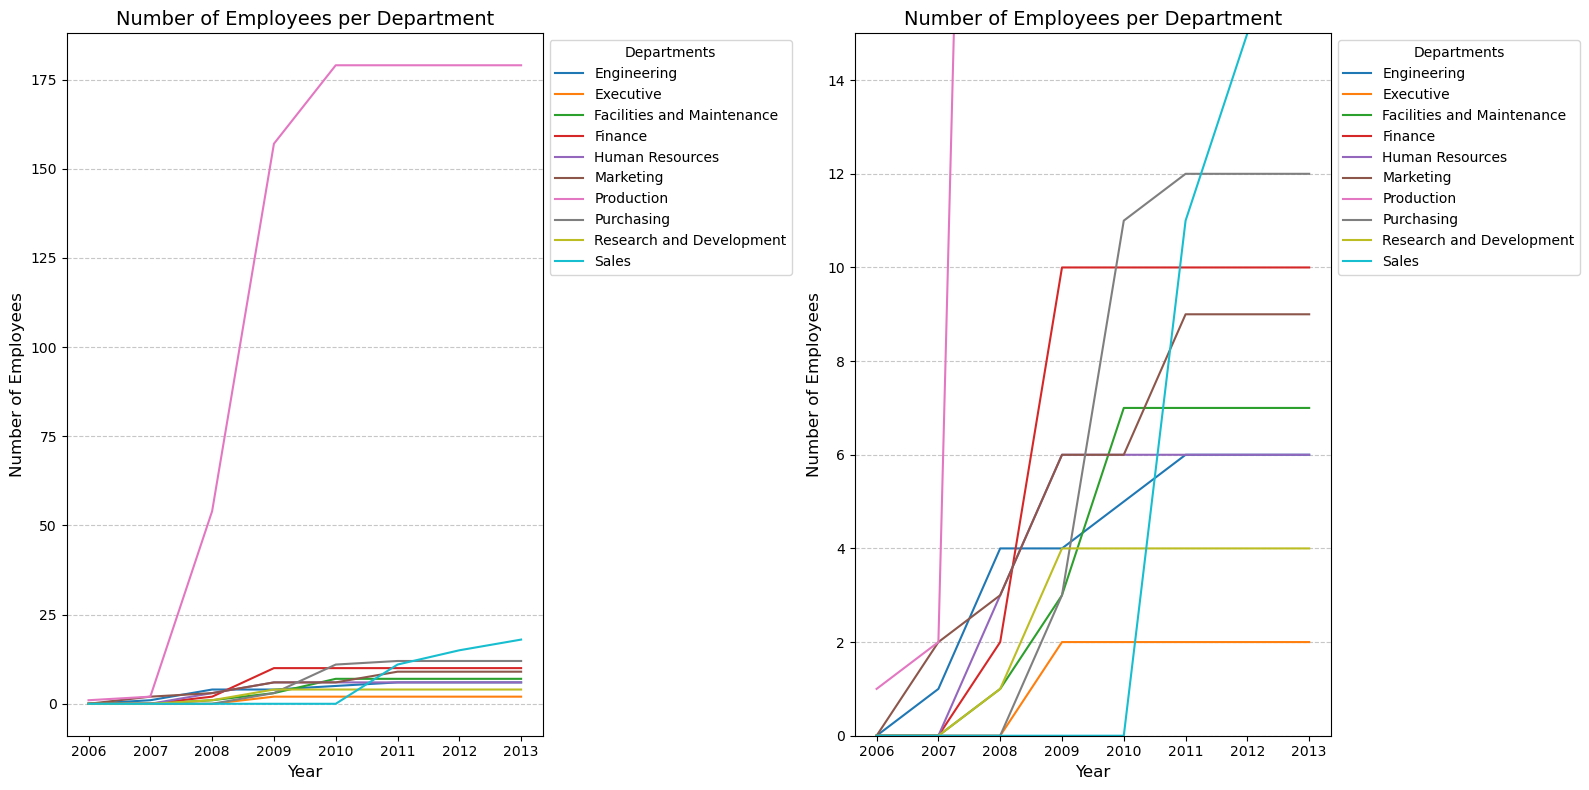

In [13]:
# The cumulative number of employees per department.

# Query that retrives number of new hires by department and year.
# Some deparments are excluded. 
# The cumulative number of employees per department is calculated. 
query = """
WITH AllDepartments AS (
    SELECT DISTINCT ED.Department
    FROM HumanResources.vEmployeeDepartment AS ED
    WHERE ED.Department NOT IN (
        'Document Control', 'Information Services', 'Tool Design', 
        'Shipping and Receiving', 'Quality Assurance', 'Production Control'
    )
),
AllYears AS (
    SELECT DISTINCT YEAR(E.HireDate) AS Year
    FROM HumanResources.Employee AS E
),
NewHiresData AS (
    SELECT 
        YEAR(E.HireDate) AS Year,
        ED.Department,
        COUNT(E.BusinessEntityID) AS NewHires
    FROM HumanResources.Employee AS E
    INNER JOIN HumanResources.vEmployeeDepartment AS ED
        ON E.BusinessEntityID = ED.BusinessEntityID
    GROUP BY 
        YEAR(E.HireDate),
        ED.Department
)
SELECT 
    A.Year,
    D.Department,
    COALESCE(N.NewHires, 0) AS NewHires,
    SUM(COALESCE(N.NewHires, 0)) OVER (PARTITION BY D.Department ORDER BY A.Year ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS CumulativeNewHires
FROM 
    AllYears A
CROSS JOIN 
    AllDepartments D
LEFT JOIN 
    NewHiresData N
    ON A.Year = N.Year AND D.Department = N.Department
ORDER BY 
    A.Year, 
    D.Department;
"""

df = pd.read_sql(query, engine)
pivot_cumulative_new_hires = df.pivot(index="Year", columns="Department", values="CumulativeNewHires")

# Plot ddata
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 1
for department in pivot_cumulative_new_hires.columns:
    axes[0].plot(pivot_cumulative_new_hires.index, pivot_cumulative_new_hires[department], label=department)
    
axes[0].set_title("Number of Employees per Department", fontsize=14)
axes[0].set_xlabel("Year", fontsize=12)
axes[0].set_ylabel("Number of Employees", fontsize=12)
axes[0].legend(title="Departments", loc="upper left", bbox_to_anchor=(1, 1))
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# 2
for department in pivot_cumulative_new_hires.columns:
    axes[1].plot(pivot_cumulative_new_hires.index, pivot_cumulative_new_hires[department], label=department)
    
axes[1].set_title("Number of Employees per Department", fontsize=14)
axes[1].set_xlabel("Year", fontsize=12)
axes[1].set_ylabel("Number of Employees", fontsize=12)
axes[1].set_ylim(0, 15)  # limit y-axis
axes[1].legend(title="Departments", loc="upper left", bbox_to_anchor=(1, 1))
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

I graferna har flera avdelningar valts att exkluderas. I den högra grafen är y-axelns kapad. Båda för att enklare läsa data och urskilja mönster.  

Företaget har under åren varit på en tillväxtresa för alla avdelningar. 

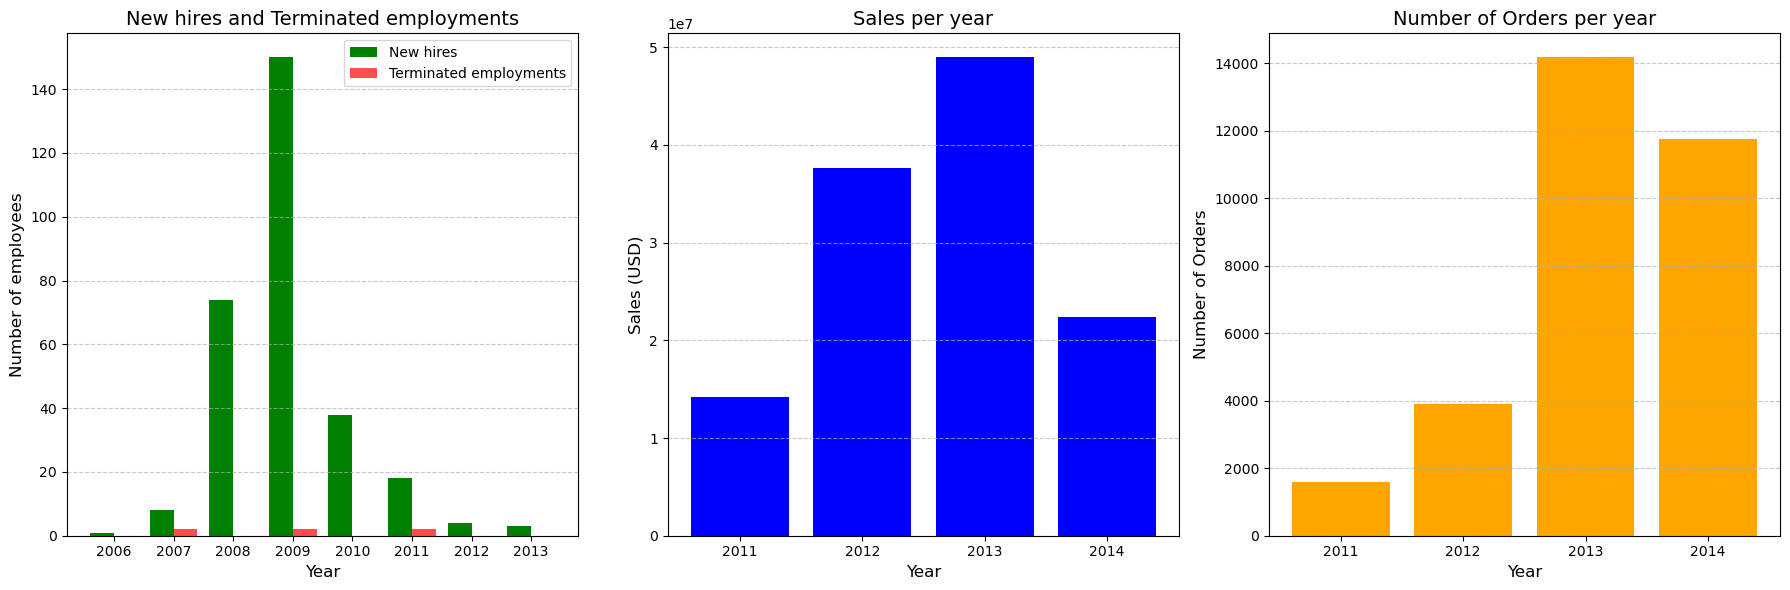

In [8]:
# New hires, terminated employments, sales and number of orders per year.

# Queries that retrives number of new hires and terminated employees by department, sales and number of orders per year.
query_hires = '''
SELECT 
    YEAR(HireDate) AS Year,
    SUM(CASE WHEN HireDate IS NOT NULL THEN 1 ELSE 0 END) AS EmployeeCount_Hired,
    SUM(CASE WHEN EndDate IS NOT NULL THEN 1 ELSE 0 END) AS EmployeeCount_Ended
FROM 
    HumanResources.Employee E
LEFT JOIN 
    HumanResources.EmployeeDepartmentHistory EDH 
    ON E.BusinessEntityID = EDH.BusinessEntityID
GROUP BY 
    YEAR(HireDate)
ORDER BY 
    YEAR(HireDate);
'''

query_sales = '''
SELECT 
    YEAR(OrderDate) AS Year,
    SUM(TotalDue) AS SalesAmount
FROM 
    Sales.SalesOrderHeader
GROUP BY 
    YEAR(OrderDate)
ORDER BY 
    YEAR(OrderDate);
'''

query_orders = '''
SELECT 
    YEAR(OrderDate) AS Year,
    COUNT(SalesOrderID) AS OrderCount
FROM 
    Sales.SalesOrderHeader
GROUP BY 
    YEAR(OrderDate)
ORDER BY 
    YEAR(OrderDate);
'''

# Läs in data från SQL
hires_df = pd.read_sql(query_hires, engine)
sales_df = pd.read_sql(query_sales, engine)
orders_df = pd.read_sql(query_orders, engine)

# Plot data
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1:
width = 0.4
axes[0].bar(hires_df["Year"] - width/2, hires_df["EmployeeCount_Hired"], width=width, color="green", label="New hires")
axes[0].bar(hires_df["Year"] + width/2, hires_df["EmployeeCount_Ended"], width=width, color="red", label="Terminated employments", alpha=0.7)
axes[0].set_title("New hires and Terminated employments", fontsize=14)
axes[0].set_xlabel("Year", fontsize=12)
axes[0].set_ylabel("Number of employees", fontsize=12)
axes[0].set_xticks(hires_df["Year"])
axes[0].legend()
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# 2:
axes[1].bar(sales_df["Year"], sales_df["SalesAmount"], color="blue", label="Sales")
axes[1].set_title("Sales per year", fontsize=14)
axes[1].set_xlabel("Year", fontsize=12)
axes[1].set_ylabel("Sales (USD)", fontsize=12)
axes[1].set_xticks(sales_df["Year"])
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# 3:
axes[2].bar(orders_df["Year"], orders_df["OrderCount"], color="orange", label="Number of Orders")
axes[2].set_title("Number of Orders per year", fontsize=14)
axes[2].set_xlabel("Year", fontsize=12)
axes[2].set_ylabel("Number of Orders", fontsize=12)
axes[2].set_xticks(orders_df["Year"])
axes[2].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

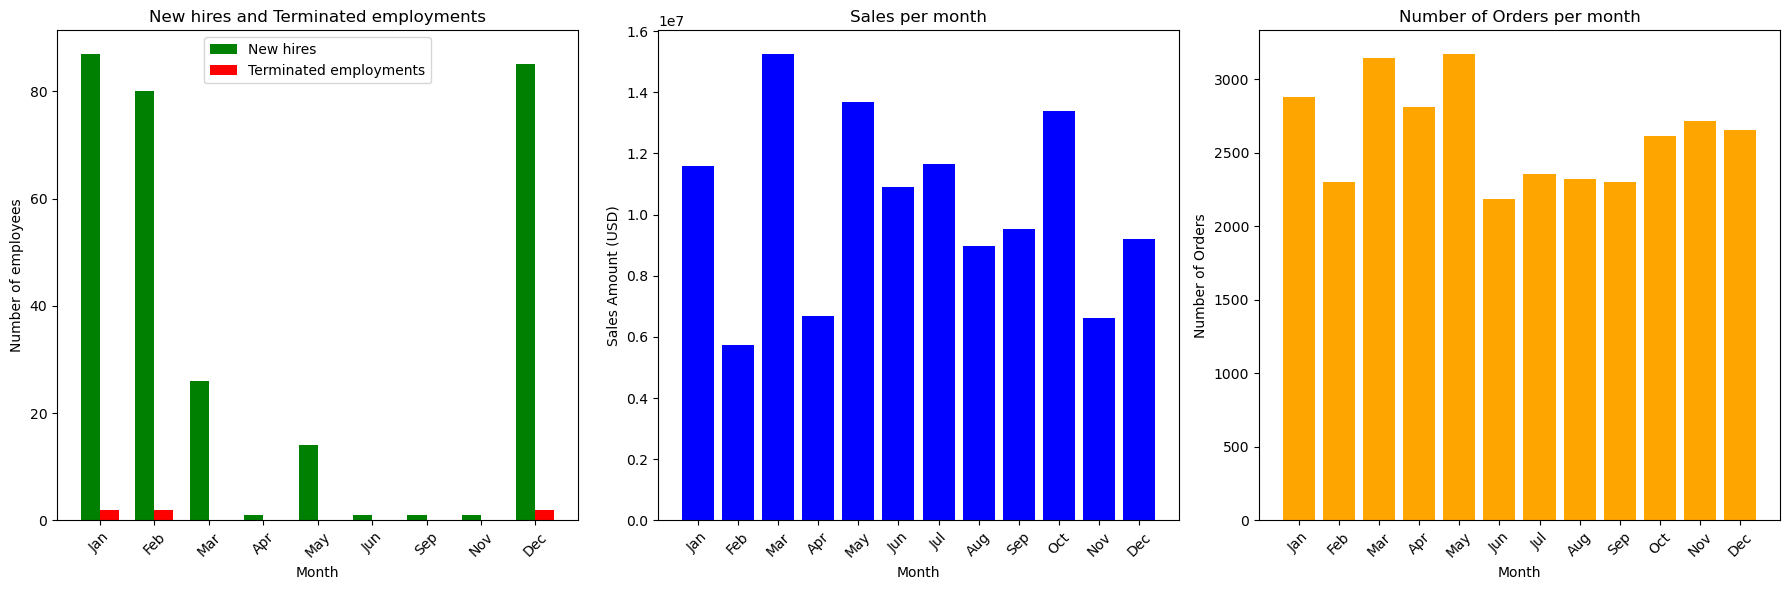

In [ ]:
# New hires, terminated employments, sales and number of orders per month.

# Queries that retrives number of new hires and terminated employees by department, sales and number of orders per month.
query_hires = '''
SELECT 
    MONTH(HireDate) AS Month,
    SUM(CASE WHEN HireDate IS NOT NULL THEN 1 ELSE 0 END) AS EmployeeCount_Hired,
    SUM(CASE WHEN EndDate IS NOT NULL THEN 1 ELSE 0 END) AS EmployeeCount_Ended
FROM 
    HumanResources.Employee E
LEFT JOIN 
    HumanResources.EmployeeDepartmentHistory EDH 
    ON E.BusinessEntityID = EDH.BusinessEntityID
GROUP BY 
    MONTH(HireDate)
ORDER BY 
    MONTH(HireDate);
'''
query_sales = '''
SELECT 
    MONTH(OrderDate) AS Month,
    SUM(TotalDue) AS SalesAmount
FROM Sales.SalesOrderHeader
GROUP BY MONTH(OrderDate)
ORDER BY MONTH(OrderDate);
'''
query_orders = '''
SELECT 
    MONTH(OrderDate) AS Month,
    COUNT(SalesOrderID) AS OrderCount
FROM Sales.SalesOrderHeader
GROUP BY MONTH(OrderDate)
ORDER BY MONTH(OrderDate);
'''

hires_df = pd.read_sql(query_hires, engine)
sales_df = pd.read_sql(query_sales, engine)
orders_df = pd.read_sql(query_orders, engine)

# Include month names in the right order
months_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
months = pd.DataFrame({"Month": range(1, 13)})

hires_terminated_df = pd.merge(months, hires_df, on="Month", how="left").fillna({"EmployeeCount_Hired": 0, "EmployeeCount_Ended": 0})
sales_df = pd.merge(months, sales_df, on="Month", how="left").fillna({"SalesAmount": 0})
orders_df = pd.merge(months, orders_df, on="Month", how="left").fillna({"OrderCount": 0})
hires_df["Month"] = hires_df["Month"].map(lambda x: months_order[x-1])
sales_df["Month"] = sales_df["Month"].map(lambda x: months_order[x-1])
orders_df["Month"] = orders_df["Month"].map(lambda x: months_order[x-1])
 
# Plot data
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1
bar_width = 0.35
x = np.arange(len(hires_df["Month"]))

axes[0].bar(x - bar_width/2, hires_df["EmployeeCount_Hired"], width=bar_width, color="green", label="New hires")
axes[0].bar(x + bar_width/2, hires_df["EmployeeCount_Ended"], width=bar_width, color="red", label="Terminated employments")
axes[0].set_xticks(x)
axes[0].set_xticklabels(hires_df["Month"], rotation=45)
axes[0].set_title("New hires and Terminated employments")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Number of employees")
axes[0].legend()

# 2
axes[1].bar(sales_df["Month"], sales_df["SalesAmount"], color="blue")
axes[1].set_title("Sales per month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Sales Amount (USD)")
axes[1].tick_params(axis="x", rotation=45)

# 3
axes[2].bar(orders_df["Month"], orders_df["OrderCount"], color="orange")
axes[2].set_title("Number of Orders per month")
axes[2].set_xlabel("Month")
axes[2].set_ylabel("Number of Orders")
axes[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

Den stora ökningen i anställningar kom 2008 för att nå sin topp under 2009 och sedan trappa av. 
Ingen tydlig orsak till nyanställning förutom uppstart inom företaget (först produktion, sedan försäljning) har identifierats. 

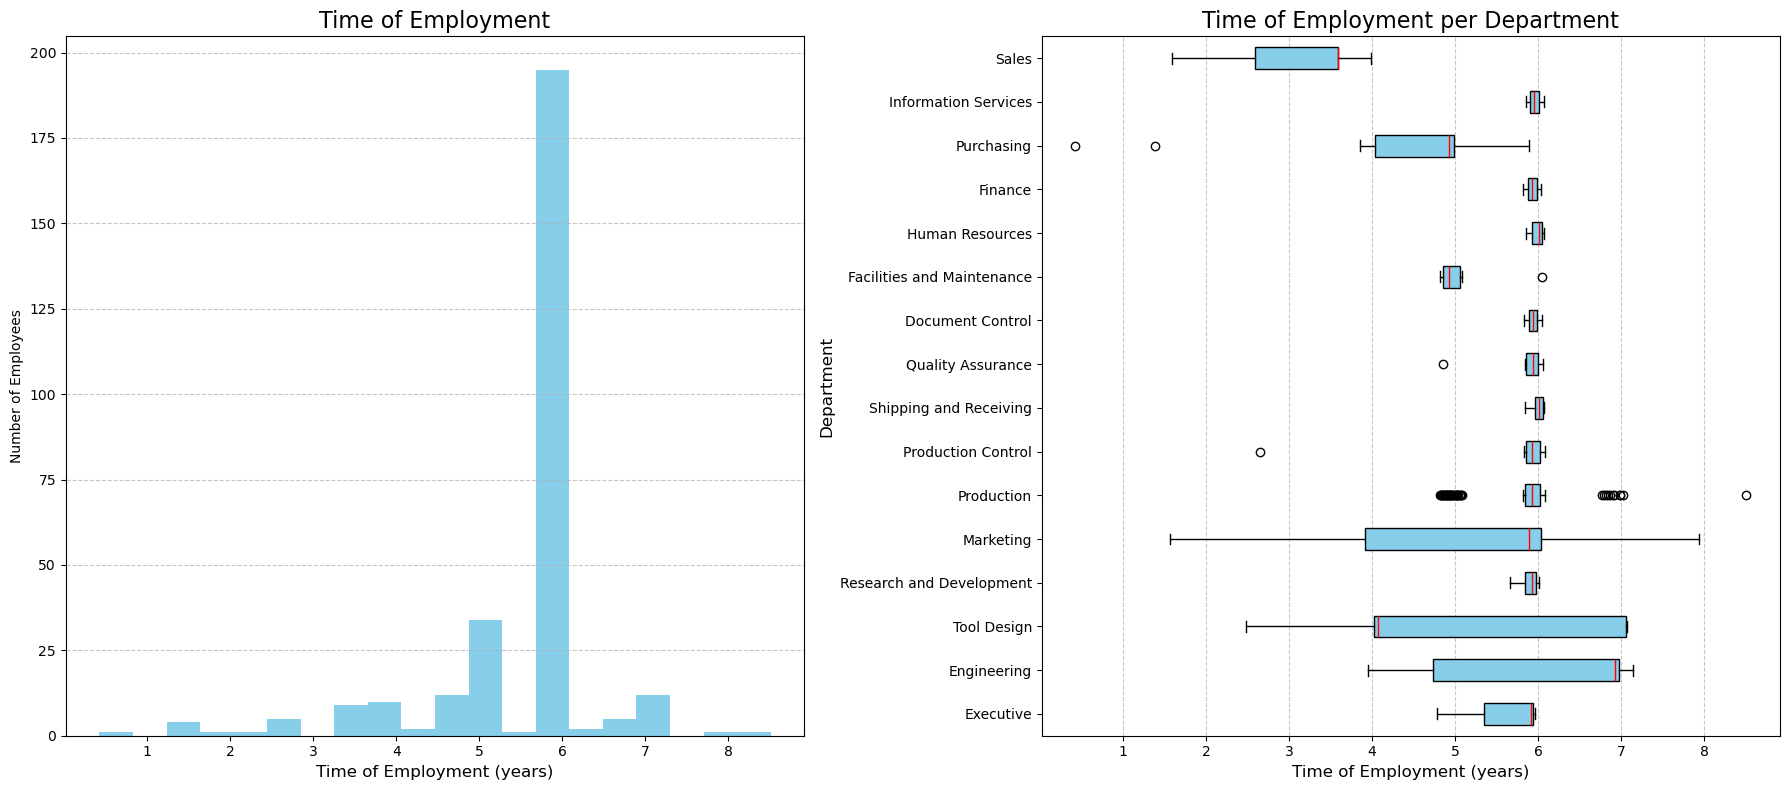

In [113]:
# Time of Employment.

# Query that retrives time of employment and department for each employee. 
# If no end date, end date is set to 2014-12-31 since that's the last year that contains data in the database. 
query = """
SELECT 
    ED.Department,
    DATEDIFF(DAY, E.HireDate, 
        CASE 
            WHEN H.EndDate IS NOT NULL THEN H.EndDate
            ELSE '2014-12-31'
        END
    ) / 365.0 AS YearsEmployed
FROM HumanResources.Employee AS E
INNER JOIN HumanResources.vEmployeeDepartment AS ED
    ON E.BusinessEntityID = ED.BusinessEntityID
LEFT JOIN HumanResources.EmployeeDepartmentHistory AS H
    ON E.BusinessEntityID = H.BusinessEntityID;
"""

df = pd.read_sql(query, engine)

# Plot data
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1
axes[0].hist(df["YearsEmployed"], bins=20, color="skyblue")
axes[0].set_title("Time of Employment", fontsize=16)
axes[0].set_xlabel("Time of Employment (years)", fontsize=12)
axes[0].set_ylabel("Number of Employees")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# 2
departments = df["Department"].unique()
data = [df[df["Department"] == dept]["YearsEmployed"].dropna() for dept in departments]

axes[1].boxplot(data, vert=False, patch_artist=True, 
                boxprops=dict(facecolor='skyblue', color='black'),
                medianprops=dict(color='red'))
axes[1].set_yticks(range(1, len(departments) + 1))
axes[1].set_yticklabels(departments, fontsize=10)
axes[1].set_title("Time of Employment per Department", fontsize=16)
axes[1].set_xlabel("Time of Employment (years)", fontsize=12)
axes[1].set_ylabel("Department", fontsize=12)
axes[1].grid(axis="x", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

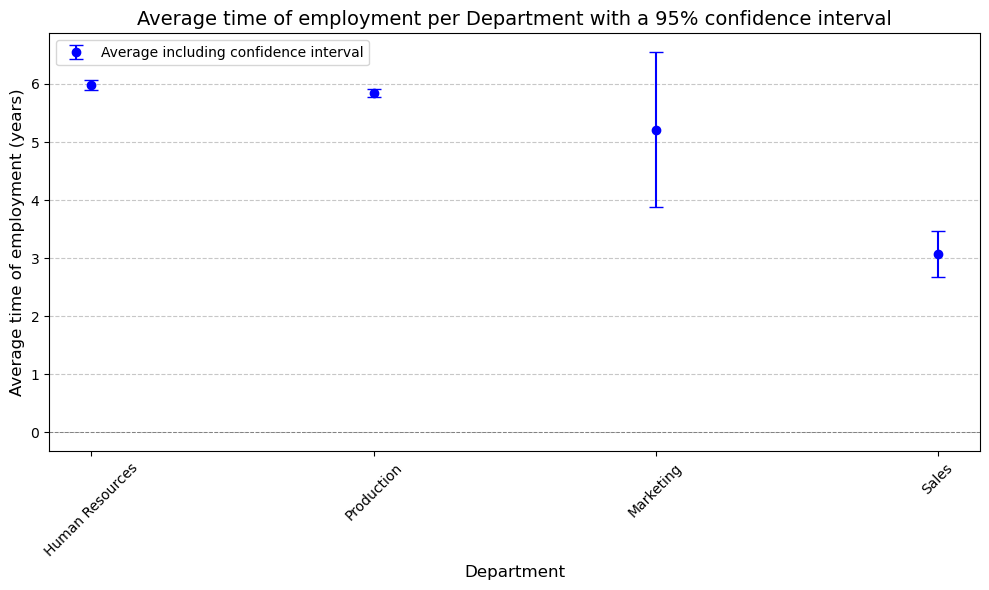

In [ ]:
# Comparison of the average time of employment for four departments to see if there is a statistically significant difference between departments. 

# Query that retrives time of employment and department for each employee. 
# If no end date, end date is set to 2014-12-31 since that's the last year that contains data in the database.
# Only four departments are included. 
query = """
SELECT 
    ED.Department,
    DATEDIFF(DAY, E.HireDate, 
        CASE 
            WHEN H.EndDate IS NOT NULL THEN H.EndDate
            ELSE '2014-12-31'
        END
    ) / 365.0 AS YearsEmployed
FROM HumanResources.Employee AS E
INNER JOIN HumanResources.vEmployeeDepartment AS ED
    ON E.BusinessEntityID = ED.BusinessEntityID
LEFT JOIN HumanResources.EmployeeDepartmentHistory AS H
    ON E.BusinessEntityID = H.BusinessEntityID
WHERE ED.Department IN ('Sales', 'Human Resources', 'Production', 'Marketing')
"""

df = pd.read_sql(query, engine)

# Confidence interval using scipy
def calculate_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std_err = stats.sem(data) 
    ci = stats.t.interval(confidence, len(data)-1, loc=mean, scale=std_err)
    return mean, ci[0], ci[1]

# Calculate confidence intervals for each department
results = []
for department in df["Department"].unique():
    dept_data = df[df["Department"] == department]["YearsEmployed"]
    mean, ci_lower, ci_upper = calculate_confidence_interval(dept_data)
    results.append({"Department": department, "Mean": mean, "CI_Lower": ci_lower, "CI_Upper": ci_upper})

ci_df = pd.DataFrame(results).sort_values(by="Mean", ascending=False)

# Plot data
plt.figure(figsize=(10, 6))

plt.errorbar(ci_df["Department"], ci_df["Mean"], 
             yerr=[ci_df["Mean"] - ci_df["CI_Lower"], ci_df["CI_Upper"] - ci_df["Mean"]],
             fmt='o', capsize=5, color='blue', label="Average including confidence interval")
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)

plt.title("Average time of employment per Department with a 95% confidence interval", fontsize=14)
plt.xlabel("Department", fontsize=12)
plt.ylabel("Average time of employment (years)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.legend()
plt.show()

Överlappande konfidensintervall tyder på att det inte finns någon statisktiskt säkerställd skillnad i anställningstid mellan avdelningar.

In [14]:
# Comparison of the average time of employment of the Production and Sales departments to see if there is a statistically significant difference between departments.

# Query that retrives time of employment and department for each employee. 
# If no end date, end date is set to 2014-12-31 since that's the last year that contains data in the database.
# Only two departments are included. 
query = """
SELECT 
    ED.Department,
    DATEDIFF(DAY, E.HireDate, ISNULL(H.EndDate, '2014-12-31')) / 365.0 AS YearsEmployed
FROM HumanResources.Employee AS E
INNER JOIN HumanResources.vEmployeeDepartment AS ED
    ON E.BusinessEntityID = ED.BusinessEntityID
LEFT JOIN HumanResources.EmployeeDepartmentHistory AS H
    ON E.BusinessEntityID = H.BusinessEntityID
    AND H.EndDate IS NOT NULL
WHERE ED.Department IN ('Sales', 'Production')  -- Two departments for t-test
"""

df = pd.read_sql(query, engine)

# Summary stats for each department
summary_stats = df.groupby("Department")["YearsEmployed"].agg(
    Mean="mean", StdDev="std", Count="count"
).round(4).reset_index()

print("Summary:")
print(tabulate(summary_stats, headers="keys", tablefmt="pretty", showindex=False))

# t-test
production_data = df.query("Department == 'Production'")["YearsEmployed"]
sales_data = df.query("Department == 'Sales'")["YearsEmployed"]

t_stat, p_value = ttest_ind(production_data, sales_data, equal_var=False)

t_test_results = {
    "T-stat": round(t_stat, 4),
    "P-value": round(p_value, 4),
    "Significance": "Yes" if p_value < 0.05 else "No"
}

print("\nT-test results:")
print(tabulate([t_test_results], headers="keys", tablefmt="pretty"))

# Statistical significance conclusion
if p_value < 0.01:
    print("\nDet finns en statistiskt signifikant skillnad mellan anställningstiden för Production och Sales.")
else:
    print("\nDet finns ingen statistiskt signifikant skillnad mellan anställningstiden för Production och Sales.")

Summary:
+------------+--------+--------+-------+
| Department |  Mean  | StdDev | Count |
+------------+--------+--------+-------+
| Production | 5.8437 | 0.5075 |  179  |
|   Sales    | 3.0715 | 0.8112 |  18   |
+------------+--------+--------+-------+

T-test results:
+---------+---------+--------------+
| T-stat  | P-value | Significance |
+---------+---------+--------------+
| 14.2221 |   0.0   |     Yes      |
+---------+---------+--------------+

Det finns en statistiskt signifikant skillnad mellan anställningstiden för Production och Sales.


Lön i föhållande till kön och roll

Kvinnor har en högre genomsnittlig lön än män, skillnaden är dock inte statistiskt säkerställd. 
Vidare analys visar att oavsett kön har alla samma lön för samma roll. 
De anställda med en roll inom en högre befattning (chefer) samt avdelningar med generellt en högre utbildningsnivå (ledning, ingenjörer, forskare) har en högre lön. 
Kvinnor har en högre andel anställda inom högre befattningar än män, vilket kan vara en förklaring till varför de har en i genomsnitt högre lön än män på företaget. 

För att kunna säkerställa vad skillnad i lön på behöver vidare analys göras som tar hänsyn till alla faktorer som kan tänkas påverka lön (roll, kön, avdelning, anställningstid, ålder, utbildningsnivå etc). T ex en linjär regressionsmodell. 

Försäljare får en bonus på sin lön (som inte är inkluderat i datan för analys kring timlön). En korrelationsanalys mellan bonus och försäljning per säljare (föregående år) visar att det finns ett positivt samband. 

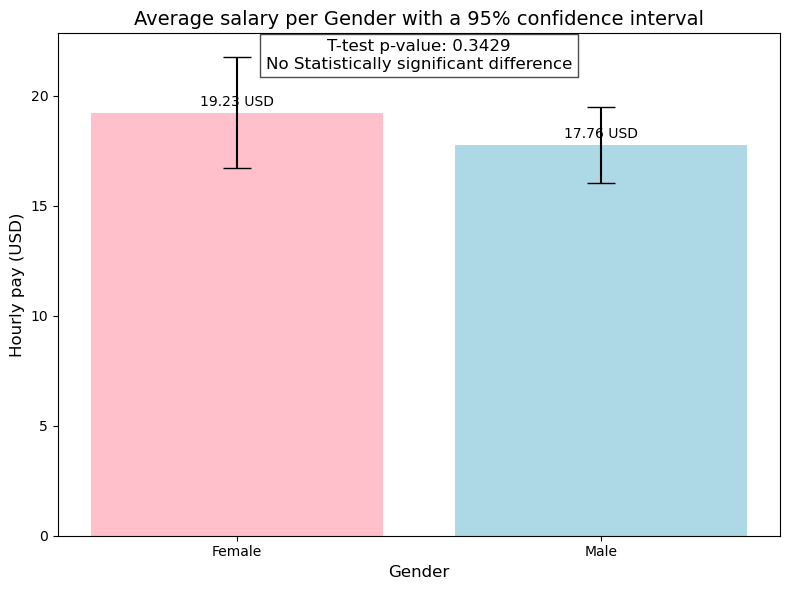

In [15]:
# Average salary per gender.

# Query that retrives the gender and hourly pay per employee. 
# Only the latest salary per employee is included. 
query = """
SELECT 
    E.Gender,
    PH.Rate AS HourlyPay
FROM 
    HumanResources.Employee AS E
INNER JOIN 
    HumanResources.EmployeePayHistory AS PH
    ON E.BusinessEntityID = PH.BusinessEntityID
WHERE 
    PH.RateChangeDate = (
        SELECT MAX(PH2.RateChangeDate)
        FROM HumanResources.EmployeePayHistory AS PH2
        WHERE PH2.BusinessEntityID = PH.BusinessEntityID
    );
"""
df = pd.read_sql(query, engine)
df['Gender'] = df['Gender'].replace({'M': 'Male', 'F': 'Female'})


# Confidence interval using scipy
def calculate_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std_err = stats.sem(data) 
    ci = stats.t.interval(confidence, len(data)-1, loc=mean, scale=std_err)  
    return mean, ci[0], ci[1]  

# Calculate confidence intervals per gender
results = []
for gender in df["Gender"].unique():
    gender_data = df[df['Gender'] == gender]['HourlyPay']
    mean, ci_lower, ci_upper = calculate_confidence_interval(gender_data)
    results.append({"Gender": gender, "Mean": mean, "CI_Lower": ci_lower, "CI_Upper": ci_upper})

ci_df = pd.DataFrame(results).sort_values(by="Mean", ascending=False)

# t-test
t_stat, p_value = ttest_ind(df[df['Gender'] == 'Male']['HourlyPay'], df[df['Gender'] == 'Female']['HourlyPay'], equal_var=False)
significance_text = f"T-test p-value: {p_value:.4f}\n"
significance_text += "Statistically significant difference" if p_value < 0.05 else "No Statistically significant difference"


# Plot data
plt.figure(figsize=(8, 6))

plt.bar(
    ci_df['Gender'], 
    ci_df['Mean'], 
    yerr=[ci_df['Mean'] - ci_df['CI_Lower'], ci_df['CI_Upper'] - ci_df['Mean']], 
    capsize=10,
    color=['pink', 'lightblue'], 
)

for i, val in enumerate(ci_df['Mean']):
    plt.text(i, val + 0.3, f"{val:.2f} USD", ha='center', fontsize=10)

plt.title("Average salary per Gender with a 95% confidence interval", fontsize=14)
plt.ylabel("Hourly pay (USD)", fontsize=12)
plt.xlabel("Gender", fontsize=12)
plt.text(0.5, max(ci_df['Mean']) + 2, significance_text, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

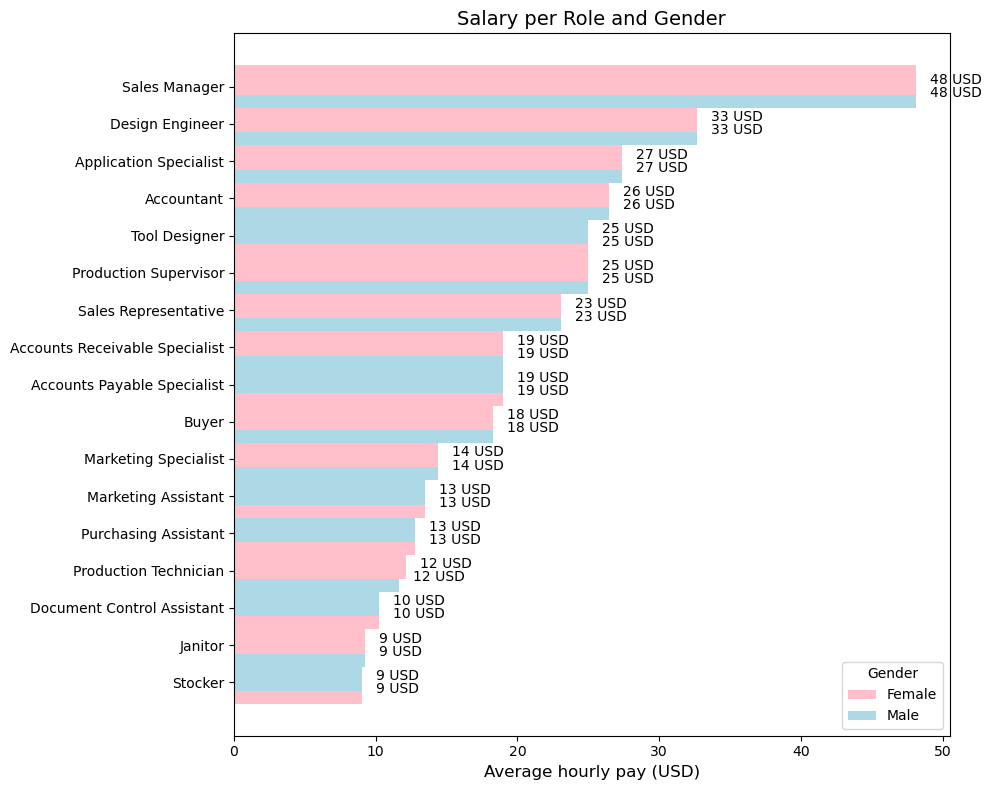

In [16]:
# Average salary per gender and role.

# Query that retrives the averagre hourly pay per role och gender.  
query = """ 
SELECT 
    CASE 
        WHEN E.JobTitle LIKE 'Production Supervisor%' THEN 'Production Supervisor'
        WHEN E.JobTitle LIKE 'Production Technician%' THEN 'Production Technician'
        WHEN E.JobTitle LIKE '%Sales Manager%' THEN 'Sales Manager'
        ELSE E.JobTitle
    END AS JobTitle,
    E.Gender,
    AVG(CAST(PH.Rate AS DECIMAL(10, 2))) AS AverageSalary
FROM 
    HumanResources.Employee AS E
INNER JOIN 
    HumanResources.EmployeePayHistory AS PH
    ON E.BusinessEntityID = PH.BusinessEntityID
GROUP BY 
    CASE 
        WHEN E.JobTitle LIKE 'Production Supervisor%' THEN 'Production Supervisor'
        WHEN E.JobTitle LIKE 'Production Technician%' THEN 'Production Technician'
        WHEN E.JobTitle LIKE '%Sales Manager%' THEN 'Sales Manager'
        ELSE E.JobTitle
    END,
    E.Gender
ORDER BY 
    AverageSalary,
    JobTitle;
"""
df = pd.read_sql(query, engine)
df['Gender'] = df['Gender'].replace({'M': 'Male', 'F': 'Female'})
df['Color'] = df['Gender'].map({'Male': 'lightblue', 'Female': 'pink'})

# Only including roles that have employees of both genders. 
roles_with_both_genders = (
    df.groupby('JobTitle')['Gender']
    .nunique()
    .loc[lambda x: x > 1]
    .index
)

filtered_df = df[df['JobTitle'].isin(roles_with_both_genders)]

# Plot data
plt.figure(figsize=(10, 8))


for index, role in enumerate(filtered_df['JobTitle'].unique()):
    role_data = filtered_df[filtered_df['JobTitle'] == role]
    for gender_index, (_, row) in enumerate(role_data.iterrows()):
        plt.barh(
            y=index + (gender_index * 0.35 - 0.35 / 2), 
            width=row['AverageSalary'],
            color=row['Color'],
            label=row['Gender'] if index == 0 else "" 
        )
        plt.text(
            row['AverageSalary'] + 1, 
            index + (gender_index * 0.35 - 0.35 / 2), 
            f"{row['AverageSalary']:.0f} USD", 
            va="center"
        )

plt.yticks(range(len(filtered_df['JobTitle'].unique())), filtered_df['JobTitle'].unique(), fontsize=10)
plt.xlabel("Average hourly pay (USD)", fontsize=12)
plt.title("Salary per Role and Gender", fontsize=14)
plt.legend(title="Gender", loc="lower right", fontsize=10)


plt.tight_layout()
plt.show()

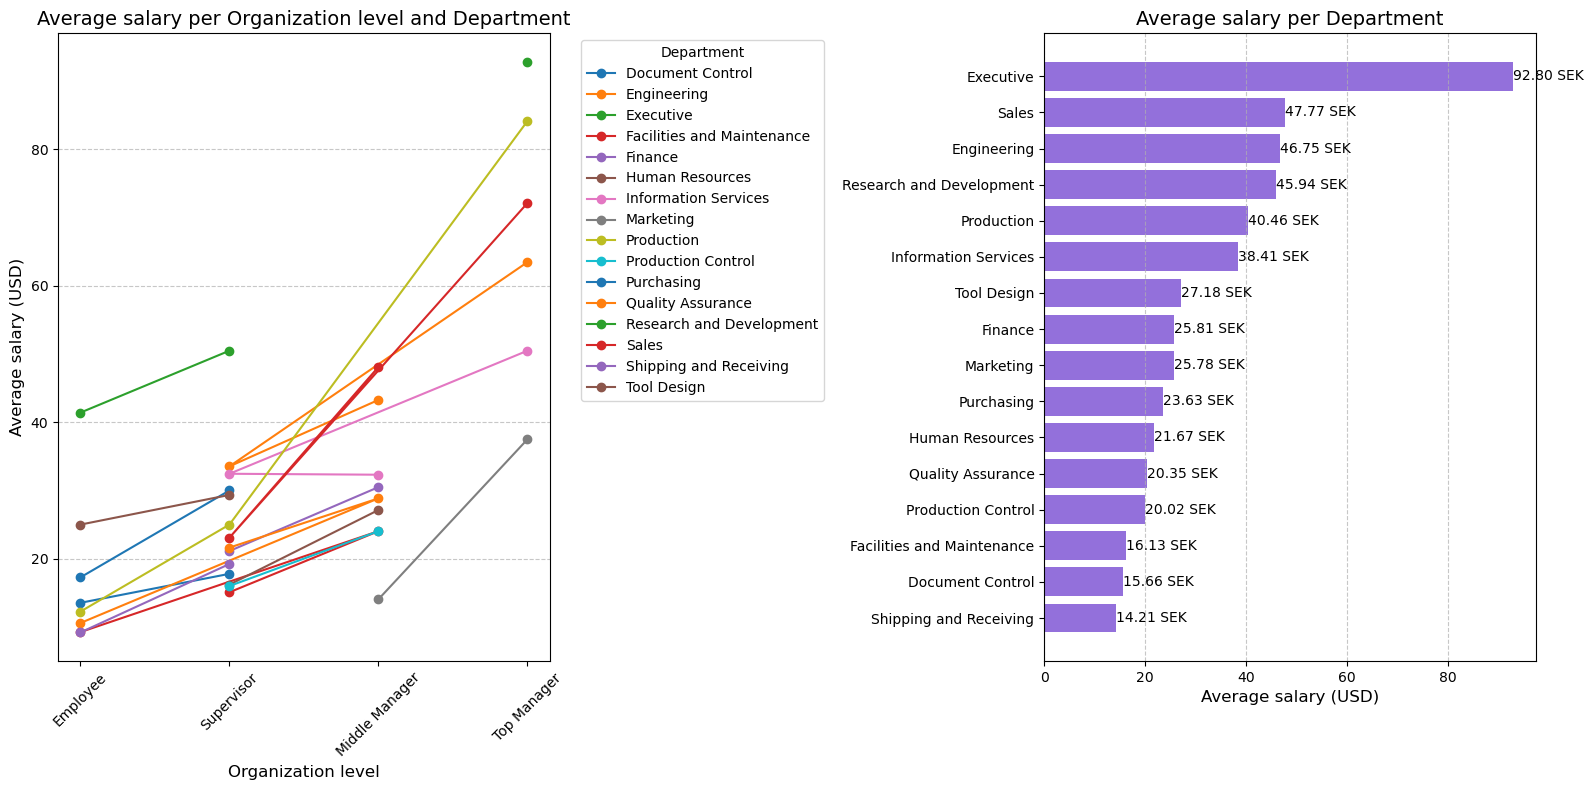

In [155]:
# Average salary in relation to department and position level.

# Query that retirves average salary in relation to department and position level.
query = """
SELECT 
    ED.Department,
    CASE 
        WHEN E.OrganizationLevel IS NULL THEN 'Top Manager'
        WHEN E.OrganizationLevel = 1 THEN 'Top Manager'
        WHEN E.OrganizationLevel = 2 THEN 'Middle Manager'
        WHEN E.OrganizationLevel = 3 THEN 'Supervisor'
        ELSE 'Employee'
    END AS RoleLevel,
    AVG(CAST(PH.Rate AS DECIMAL(10, 2))) AS AverageSalary
FROM 
    HumanResources.Employee AS E
INNER JOIN 
    (SELECT 
         BusinessEntityID, 
         Rate, 
         ROW_NUMBER() OVER (PARTITION BY BusinessEntityID ORDER BY RateChangeDate DESC) AS RowNum
     FROM HumanResources.EmployeePayHistory) AS PH
    ON E.BusinessEntityID = PH.BusinessEntityID AND PH.RowNum = 1
INNER JOIN 
    HumanResources.vEmployeeDepartment AS ED
    ON E.BusinessEntityID = ED.BusinessEntityID
GROUP BY 
    ED.Department,
    CASE 
        WHEN E.OrganizationLevel IS NULL THEN 'Top Manager'
        WHEN E.OrganizationLevel = 1 THEN 'Top Manager'
        WHEN E.OrganizationLevel = 2 THEN 'Middle Manager'
        WHEN E.OrganizationLevel = 3 THEN 'Supervisor'
        ELSE 'Employee'
    END
ORDER BY 
    ED.Department,
    RoleLevel;
"""

df = pd.read_sql(query, engine)
department_salary_df = df.groupby('Department')['AverageSalary'].mean().sort_values(ascending=False)

# Plot data
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 1
departments = df['Department'].unique()

for department in departments:
    dept_data = df[df['Department'] == department]
    axes[0].plot(dept_data['RoleLevel'], dept_data['AverageSalary'], marker='o', label=department)

axes[0].set_title("Average salary per Organization level and Department", fontsize=14)
axes[0].set_xlabel("Organization level", fontsize=12)
axes[0].set_ylabel("Average salary (USD)", fontsize=12)
axes[0].legend(title="Department", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# 2
axes[1].barh(department_salary_df.index, department_salary_df.values, color='#9370DB')
for i, val in enumerate(department_salary_df.values):
    axes[1].text(val, i, f"{val:.2f} SEK", va='center', fontsize=10)

axes[1].set_title("Average salary per Department", fontsize=14)
axes[1].set_xlabel("Average salary (USD)", fontsize=12)
axes[1].invert_yaxis()  # Invertera y-axeln för fallande ordning
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

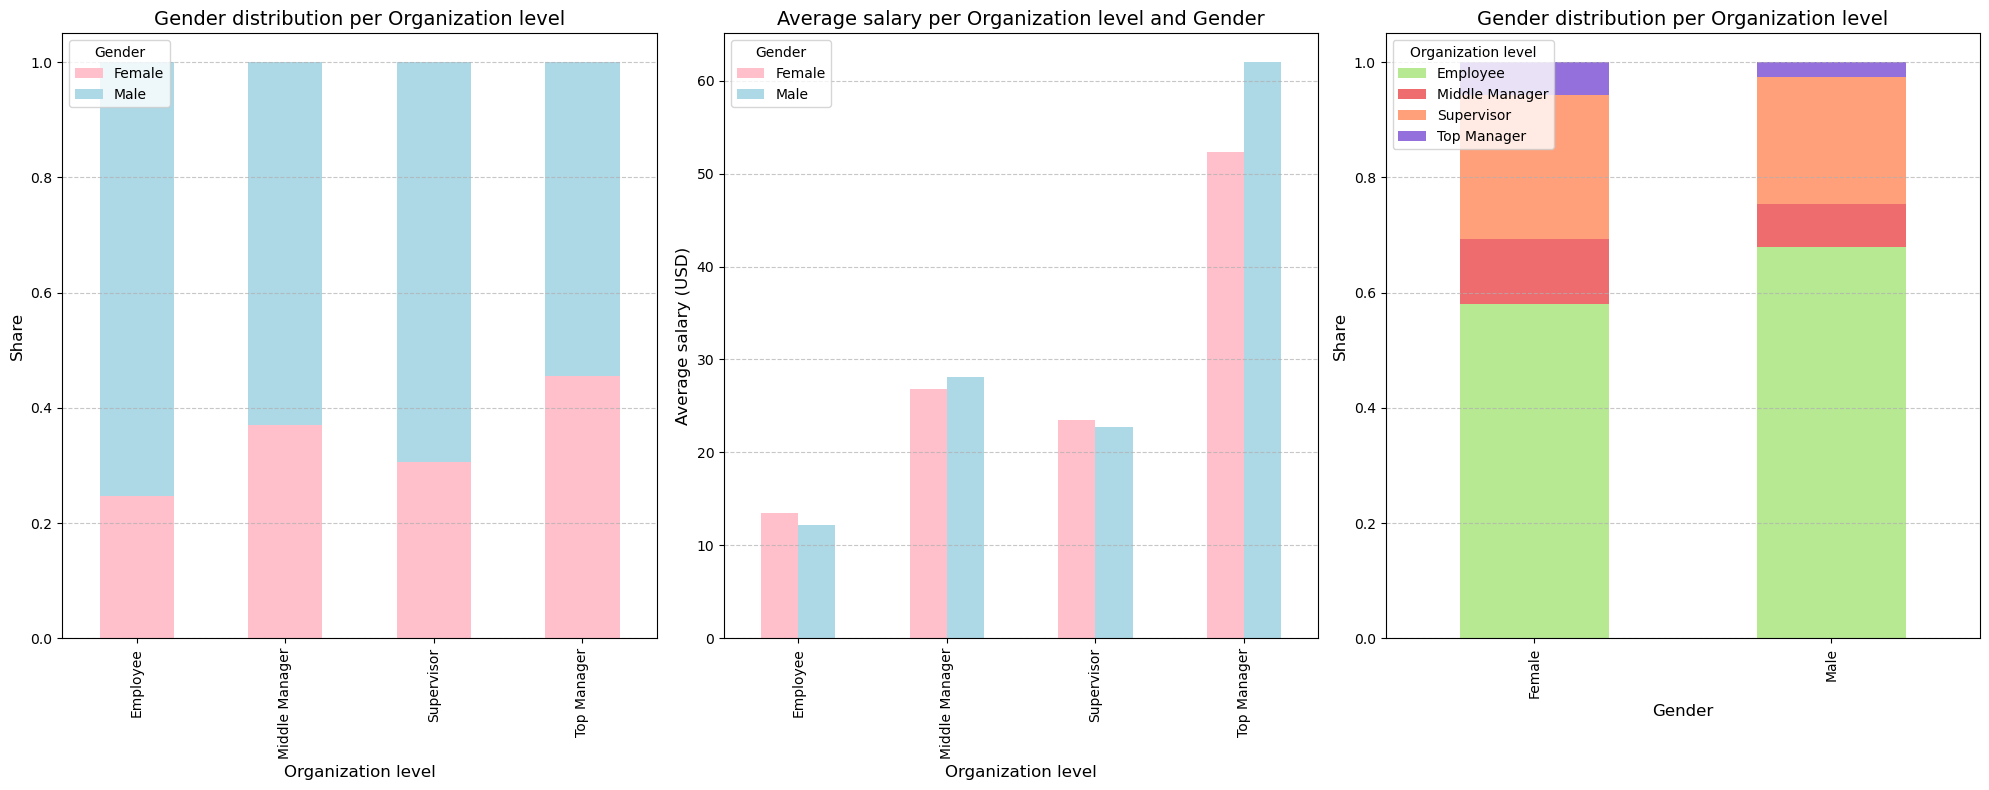

In [17]:
# Average salary in relation to gender and position level.

# Query that retirves average salary in relation to gender and position level.
query = """
SELECT 
    CASE 
        WHEN E.OrganizationLevel IS NULL THEN 'Top Manager'
        WHEN E.OrganizationLevel = 1 THEN 'Top Manager'
        WHEN E.OrganizationLevel = 2 THEN 'Middle Manager'
        WHEN E.OrganizationLevel = 3 THEN 'Supervisor'
        ELSE 'Employee'
    END AS RoleLevel,
    E.Gender,
    AVG(CAST(PH.Rate AS DECIMAL(10, 2))) AS AverageSalary,
    COUNT(E.BusinessEntityID) AS EmployeeCount
FROM 
    HumanResources.Employee AS E
INNER JOIN 
    HumanResources.EmployeePayHistory AS PH
    ON E.BusinessEntityID = PH.BusinessEntityID
GROUP BY 
    CASE 
        WHEN E.OrganizationLevel IS NULL THEN 'Top Manager'
        WHEN E.OrganizationLevel = 1 THEN 'Top Manager'
        WHEN E.OrganizationLevel = 2 THEN 'Middle Manager'
        WHEN E.OrganizationLevel = 3 THEN 'Supervisor'
        ELSE 'Employee'
    END,
    E.Gender
ORDER BY RoleLevel, E.Gender;
"""
df = pd.read_sql(query, engine)
df['Gender'] = df['Gender'].replace({'M': 'Male', 'F': 'Female'})

# Plot data
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# 1
gender_distribution = df.pivot_table(index='RoleLevel', columns='Gender', values='EmployeeCount', aggfunc='sum').fillna(0)
gender_distribution_norm = gender_distribution.div(gender_distribution.sum(axis=1), axis=0)

gender_distribution_norm.plot(kind='bar', stacked=True, ax=axes[0], color=['pink', 'lightblue'])
axes[0].set_title("Gender distribution per Organization level", fontsize=14)
axes[0].set_xlabel("Organization level", fontsize=12)
axes[0].set_ylabel("Share", fontsize=12)
axes[0].legend(title="Gender", loc='upper left')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# 2
salary_pivot = df.pivot(index='RoleLevel', columns='Gender', values='AverageSalary')
salary_pivot.plot(kind='bar', ax=axes[1], color=['pink', 'lightblue'])
axes[1].set_title("Average salary per Organization level and Gender", fontsize=14)
axes[1].set_xlabel("Organization level", fontsize=12)
axes[1].set_ylabel("Average salary (USD)", fontsize=12)
axes[1].legend(title="Gender", loc='upper left')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# 3
pivot = df.pivot_table(index='Gender', columns='RoleLevel', values='EmployeeCount', aggfunc='sum').fillna(0)
pivot_norm = pivot.div(pivot.sum(axis=1), axis=0)

pivot_norm.plot(kind='bar', stacked=True, ax=axes[2], color=['#B7E892', '#EE6B6E', '#FFA07A', '#9370DB']) 
axes[2].set_title("Gender distribution per Organization level", fontsize=14)
axes[2].set_xlabel("Gender", fontsize=12)
axes[2].set_ylabel("Share", fontsize=12)
axes[2].legend(title="Organization level", loc='upper left')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

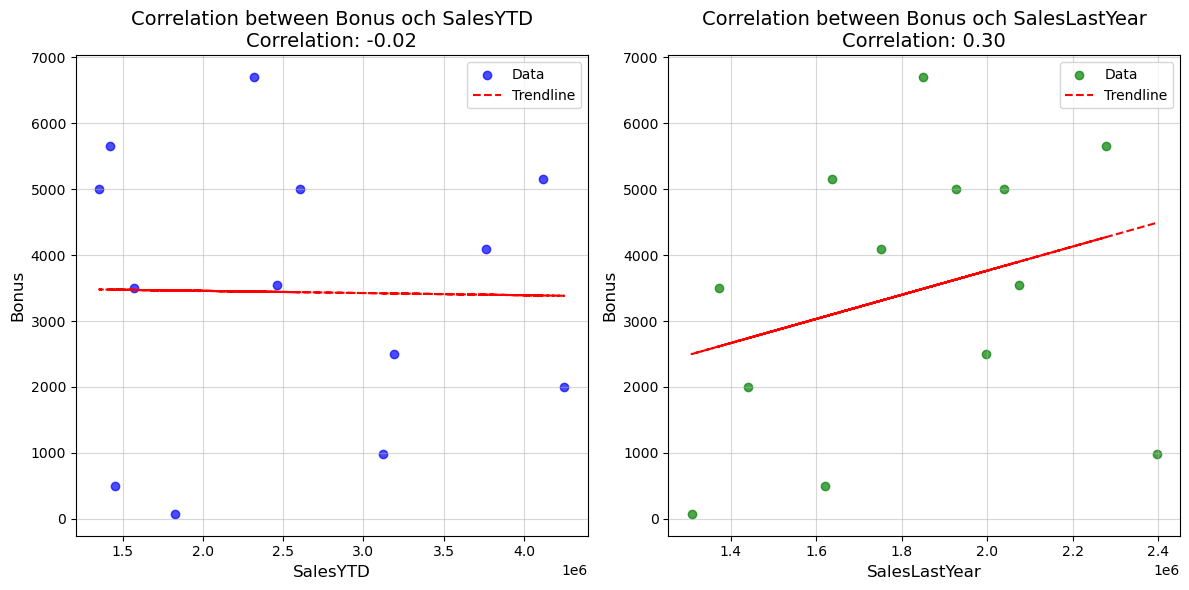

In [18]:
# Relationship between bonus and sales per salesperson. 

query = """
SELECT 
    BusinessEntityID AS SalesPersonID,
    Bonus,
    SalesYTD,
    SalesLastYear
FROM 
    Sales.SalesPerson
WHERE 
    Bonus > 0 AND SalesYTD > 0 AND SalesLastYear > 0;
"""
df = pd.read_sql(query, engine)

# Correlations
correlation_ytd = df['Bonus'].corr(df['SalesYTD'])
correlation_last_year = df['Bonus'].corr(df['SalesLastYear'])

# Plot data
plt.figure(figsize=(12, 6))

# 1
plt.subplot(1, 2, 1)
x = df['SalesYTD']
y = df['Bonus']

coeffs_ytd = np.polyfit(x, y, 1)  # Linjär regression
trendline_ytd = np.poly1d(coeffs_ytd)

plt.scatter(x, y, color="blue", alpha=0.7, label="Data")
plt.plot(x, trendline_ytd(x), color="red", linestyle="--", label="Trendline")
plt.title(f"Correlation between Bonus och SalesYTD\nCorrelation: {correlation_ytd:.2f}", fontsize=14)
plt.xlabel("SalesYTD", fontsize=12)
plt.ylabel("Bonus", fontsize=12)
plt.legend()
plt.grid(alpha=0.5)

# 2
plt.subplot(1, 2, 2)
x = df['SalesLastYear']
y = df['Bonus']

coeffs_last_year = np.polyfit(x, y, 1)  # Linjär regression
trendline_last_year = np.poly1d(coeffs_last_year)

plt.scatter(x, y, color="green", alpha=0.7, label="Data")
plt.plot(x, trendline_last_year(x), color="red", linestyle="--", label="Trendline")
plt.title(f"Correlation between Bonus och SalesLastYear\nCorrelation: {correlation_last_year:.2f}", fontsize=14)
plt.xlabel("SalesLastYear", fontsize=12)
plt.ylabel("Bonus", fontsize=12)
plt.legend()
plt.grid(alpha=0.5)

plt.tight_layout()
plt.show()

##### Muntlig presentation

Jag genomförde en muntlig presentation 3/1-2025. 

##### Självutvärdering 

1. Utmaningar du haft under arbetet samt hur du hanterat dem.

Det har tagit lång tid att förstå de olika delarna inom hur man får ihop en mer avancerad query samt hur man ska hantera data i Python, även om det finns gott om information att hämta kring hur man skriver kod online. Detta har gjort att tiden varit knapp för att effektivisera och gå igenom kod. 

2. Vilket betyg du anser att du skall ha och varför.

VG - Jag tycker att jag utforskat många olika delar inom queries och python samt analyserat flera aspekter av databasen och att jag därför uppfyller kriterierna. 

3. Tips du hade gett till dig själv i början av kursen nu när du slutfört den.

Jag hade gjort ett mindre arbete och fokuserat mer på att skriva bättre kod. 